## **Parkinson detection based on sketches - PDS**


**Dataset:** https://www.kaggle.com/datasets/kmader/parkinsons-drawings

**Paper:** https://www.frontiersin.org/articles/10.3389/fneur.2017.00435/full

**Prototypical Networks:** https://arxiv.org/abs/1703.05175

## **Before running this notebook, turn on your GPU from the notebook settings of the google colab!**

## Install/import library

In [1]:
!pip install easyfsl > /dev/null

In [4]:
from PDS.PDS import functions as pds

In [ ]:
import torch
from tqdm import tqdm
from torch import nn, optim
from PDS.PDS import functions as pds
from torchvision import transforms
from easyfsl.datasets import  EasySet
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

## Download dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
! git clone https://github.com/mehrdad-dev/PDS

Cloning into 'PDS'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 156 (delta 15), reused 149 (delta 11), pack-reused 0
Receiving objects: 100% (156/156), 13.55 MiB | 29.98 MiB/s, done.
Resolving deltas: 100% (15/15), done.


## Prepare dataset

In [10]:
resize_transform = transforms.Compose(
    [
        transforms.CenterCrop([300, 600]),
        transforms.ToTensor(),
    ]
)

train_file2classid = pds.file2classid('/content/PDS/dataset/wave/training')
test_file2classid = pds.file2classid('/content/PDS/dataset/wave/testing')

In [30]:
N_WAY = 2  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_TRAINING_EPISODES = 100


train_set = EasySet('/content/PDS/specs/train_spec.json', image_size=(300, 600), transform=resize_transform)
train_set.get_labels = lambda: [instance[1] for instance in train_file2classid]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=False,
    collate_fn=train_sampler.episodic_collate_fn,
)

test_set = EasySet('/content/PDS/specs/test_spec.json', image_size=(300, 600), transform=resize_transform)
test_set.get_labels = lambda: [instance[1] for instance in test_file2classid]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=False,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


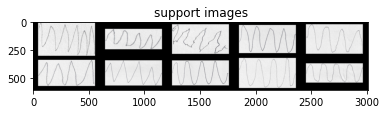

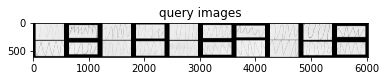

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

## Create and train model

In [31]:
CNN_backbone = resnet18(pretrained=True)
CNN_backbone.fc = nn.Flatten()
model = pds.PrototypicalNetworks(CNN_backbone).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
log_update_frequency = 10

In [32]:
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = pds.fit(model, optimizer, criterion, support_images,
                             support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency)) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 100/100 [01:37<00:00,  1.03it/s, loss=7.76e-5]


## Evaluate model

In [33]:
def evaluate_on_one_task(
    model,
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(model, data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        with tqdm(enumerate(data_loader), total=len(data_loader)) as tqdm_train:
            for episode_index, (
                support_images,
                support_labels,
                query_images,
                query_labels,
                _,
            ) in tqdm_train:
                correct, total = evaluate_on_one_task(model, support_images,
                                    support_labels, query_images, query_labels)

                total_predictions += total
                correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )

In [34]:
evaluate(model, train_loader)
evaluate(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 100/100 [00:42<00:00,  2.38it/s]

Model tested on 100 tasks. Accuracy: 100.00%



100%|██████████| 100/100 [00:42<00:00,  2.35it/s]

Model tested on 100 tasks. Accuracy: 96.40%


## Save model

In [35]:
torch.save(model.state_dict(), '/content/drive/MyDrive/parkinson_model.pth')

## Load and evaluate model

In [47]:
CNN_backbone = resnet18(pretrained=True)
CNN_backbone.fc = nn.Flatten()
model = pds.PrototypicalNetworks(CNN_backbone).cuda()
model.load_state_dict(torch.load('/content/drive/MyDrive/parkinson_model.pth'))
evaluate(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 100/100 [00:42<00:00,  2.37it/s]

Model tested on 100 tasks. Accuracy: 96.15%
